In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

sample_rate = 250

# Load data from .txt file

In [4]:
df = pd.read_csv('data/raw_cell.txt', usecols=[1,2,3,4,9,10,11], skiprows=7, index_col=None, header=None)
data = df.to_numpy()
data = data.astype(float)

In [5]:
data.shape

(79710, 7)

# Filter the raw data
## Build your own filter

In [6]:
def bandpass(start, stop, data, sample_rate = 250):
    bp_Hz = np.array([start, stop])
    b, a = signal.butter(5, bp_Hz / (sample_rate / 2.0), btype='bandpass')
    return signal.lfilter(b, a, data, axis=0)

def notch(val, data, sample_rate= 250):
    notch_freq_Hz = np.array([float(val)])
    for freq_Hz in np.nditer(notch_freq_Hz):
        bp_stop_Hz = freq_Hz + 3.0 * np.array([-1, 1])
        b, a = signal.butter(3, bp_stop_Hz / (sample_rate / 2.0), 'bandstop')
        fin = data = signal.lfilter(b, a, data)
    return fin

def fft(data, sample_rate):
    L = len(data)
    freq = np.linspace(0.0, 1.0 / (2.0 * sample_rate **-1), L // 2)
    yi = np.fft.fft(data)[1:]
    y = yi[range(int(L / 2))]
    return freq, abs(y)

## Plot the raw data

(0, 5)

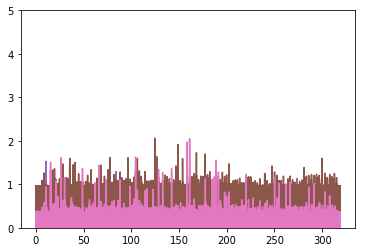

In [9]:
# raw channels
channels = []
for i in range(7):
    channels.append(data[:,i].astype(np.float))
t = len(channels[0])/sample_rate
time = np.linspace(0, t, len(channels[0]))
for i in range(len(channels)):
    plt.plot(time,channels[i])
plt.ylim(0, 5)

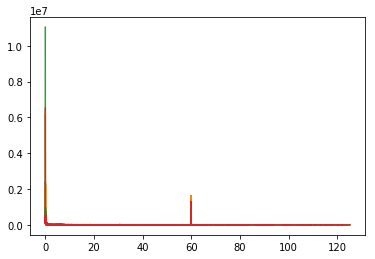

In [14]:
# fft of raw channels
for i in range(len(channels)):
    if i < 4:
        freq, y = fft(channels[i], sample_rate)
        plt.plot(freq, y)
#plt.ylim(0, 1e7)
#plt.xlim(0,100)

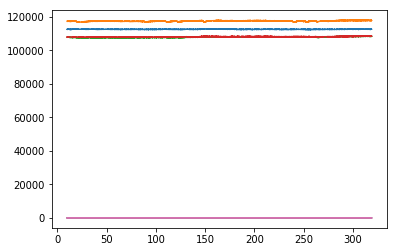

In [15]:
#applied notch filter = 60
notch_channels = []
for i in range(len(channels)):
    if i < 4:
        notch_channels.append(notch(60,channels[i], sample_rate = sample_rate))
    else:
        notch_channels.append(channels[i])
for i in range(len(notch_channels)):
    plt.plot(time[10*sample_rate:], notch_channels[i][10*sample_rate:])

(0, 100)

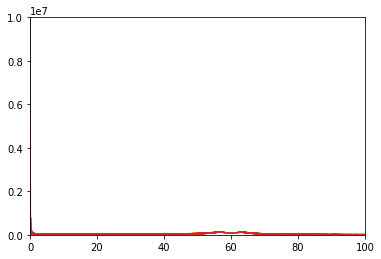

In [16]:
# fft of applied notch
for i in range(len(notch_channels)):
    if i < 4:
        freq, y = fft(notch_channels[i], sample_rate)
        plt.plot(freq, y)
plt.ylim(0, 1e7)
plt.xlim(0,100)

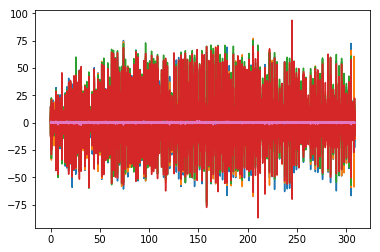

In [27]:
#applied bandpass filter = 6-25
band = (6,25)
bandpass_channels = []
for i in range(len(notch_channels)):
    if i < 4:
        bandpass_channels.append(bandpass(band[0],band[1],notch_channels[i], sample_rate = sample_rate))
    else:
        bandpass_channels.append(notch_channels[i])
#remove 10 seconds' data
final_channels = []
for i in range(len(bandpass_channels)):
    final_channels.append(bandpass_channels[i][int(10*sample_rate):])

t = len(final_channels[0])/sample_rate
time = np.linspace(0, t, len(final_channels[0]))
  
    
    
for i in range(len(bandpass_channels)):
    plt.plot(time, final_channels[i])
#plt.xlim(0,10)

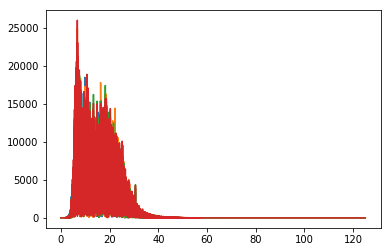

In [29]:
# fft of applied bandpass
for i in range(len(final_channels)):
    if i < 4:
        freq, y = fft(final_channels[i], sample_rate)
        plt.plot(freq, y)
#plt.ylim(0, 1e7)
#plt.xlim(0,100)

In [32]:
from scipy.signal import find_peaks

In [149]:
peaks, _ = find_peaks(abs(final_channels[4]), distance=375, height=0)

In [150]:
type(peaks)

numpy.ndarray

In [151]:
peaks.shape

(140,)

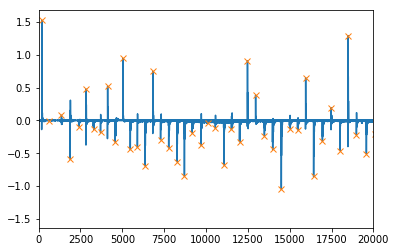

In [152]:
plt.plot(final_channels[4])
plt.plot(peaks, final_channels[4][peaks], "x")
plt.xlim(0,20000)
plt.show()

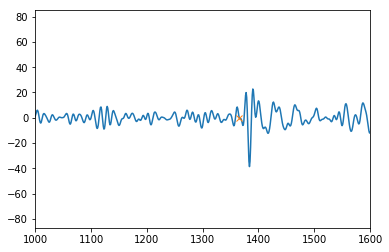

In [86]:
plt.plot(final_channels[1])
plt.plot(peaks, final_channels[4][peaks], "x")
plt.xlim(1000,1600)
plt.show()

In [96]:
final_channels[0].shape[0]

77210

In [101]:
final_array = np.zeros((4, final_channels[0].shape[0]))
for i in range(4):
    final_array[i,:] = final_channels[i]

In [105]:
final_array.shape

(4, 77210)

In [106]:
num = peaks.shape[0]

In [119]:
dataset = np.zeros((num-1, 4, 375))
dataset.shape

(139, 4, 375)

In [120]:
peaks[1]

639

In [124]:
for i in range(num-1):
    dataset[i] = final_array[:, peaks[i]+100 : peaks[i] + 475]
    
    

In [125]:
dataset.shape

(139, 4, 375)

In [164]:
def dataset_builder(rawdata):
    df = pd.read_csv(rawdata, usecols=[1,2,3,4,9,10,11], skiprows=7, index_col=None, header=None)
    data = df.to_numpy()
    data = data.astype(float)
    channels = []
    for i in range(7):
        channels.append(data[:,i].astype(np.float))
        
    notch_channels = []
    for i in range(len(channels)):
        if i < 4:
            notch_channels.append(notch(60,channels[i], sample_rate = sample_rate))
        else:
            notch_channels.append(channels[i])
            
    band = (6,25)
    bandpass_channels = []
    for i in range(len(notch_channels)):
        if i < 4:
            bandpass_channels.append(bandpass(band[0],band[1],notch_channels[i], sample_rate = sample_rate))
        else:
            bandpass_channels.append(notch_channels[i])
            
    #remove 10 seconds' data
    final_channels = []
    for i in range(len(bandpass_channels)):
        final_channels.append(bandpass_channels[i][int(10*sample_rate):])
    #find peaks
    peaks, _ = find_peaks(abs(final_channels[4]), distance=375, height=0)
    num = peaks.shape[0]
    dataset = np.zeros((num-2, 4, 375)) # leave the last two
    for i in range(num-2):
        dataset[i] = final_array[:, peaks[i]+100 : peaks[i] + 475]
        
    return dataset

    


In [165]:
class_1 = 'data/raw_cell.txt'
class_2 = 'data/raw_enhance.txt'
class_3 = 'data/raw_interlinked.txt'
class_4 = 'data/raw_stop.txt'

dataset_1 = dataset_builder(class_1)
dataset_2 = dataset_builder(class_2)
dataset_3 = dataset_builder(class_3)
dataset_4 = dataset_builder(class_4)

In [169]:
dataset_4.shape

(126, 4, 375)

In [231]:
y_1 = np.array([1,0,0,0])
y_1 = np.tile(y_1, (dataset_1.shape[0],1))

y_2 = np.array([0,1,0,0])
y_2 = np.tile(y_2, (dataset_2.shape[0],1))

y_3 = np.array([0,0,1,0])
y_3 = np.tile(y_3, (dataset_3.shape[0],1))

y_4 = np.array([0,0,0,1])
y_4 = np.tile(y_4, (dataset_4.shape[0],1))

In [232]:
y_4.shape

(126, 4)

In [233]:
y = np.concatenate((y_1, y_2, y_3, y_4), axis=0)

In [234]:
y.shape

(512, 4)

In [235]:
X = np.concatenate((dataset_1, dataset_2, dataset_3, dataset_4), axis=0)

In [239]:
X.shape[0]

512

In [241]:
X = np.reshape(X,(X.shape[0],X.shape[1]*X.shape[2]))

In [242]:
X.shape

(512, 1500)

# KNN

In [243]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [244]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = np.arange(1,9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

In [245]:
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)
    
    test_accuracy[i] = knn.score(X_test, y_test)

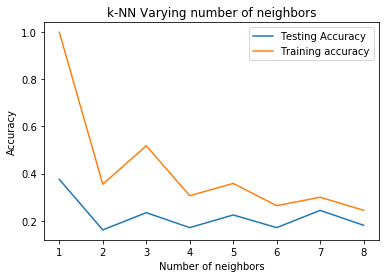

In [246]:
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [248]:
knn = KNeighborsClassifier(n_neighbors=7)

In [249]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

In [250]:
knn.score(X_test, y_test)

0.24390243902439024

In [251]:
from sklearn.metrics import confusion_matrix

In [252]:
y_pred = knn.predict(X_test)

In [261]:
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

array([[53,  0,  1,  1],
       [47,  0,  1,  2],
       [45,  1,  0,  3],
       [47,  0,  0,  4]], dtype=int64)

In [264]:
pd.crosstab(y_test.argmax(axis=1), y_pred.argmax(axis=1), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,All
True,,,,,
0,53,0,1,1,55
1,47,0,1,2,50
2,45,1,0,3,49
3,47,0,0,4,51
All,192,1,2,10,205


In [265]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': np.arange(1,50)}

In [266]:
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X,y)

E:\software\anaconda\envs\DL\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [267]:
knn_cv.best_score_

0.212890625

In [268]:
knn_cv.best_params_

{'n_neighbors': 1}